### Requisitos del proyecto
Debe contener lo siguiente:

1. Explicación del problema a resolver (cuáles son los inputs y porqué, cual es la salida y porqué, cómo se obtuvieron y de dónde)
2. Análisis de los datos (histogramas, visualización de una muestra tanto la entrada como la salida, normalización encaso de ser necesaria)
3. Separación de los datos (seleccionar un porcentaje para cada conjunto)
4. Definición, Entrenamiento y Evaluación de la red neuronal
5. Inferencia (usando los datos de prueba)
6. Comentario: explicar porqué se obtuvieron esos resultados

# LaTeX Parser

### I. Explicación del problema
_____
_____

El problema a resolver es la traducción de imágenes con ecuaciones matemáticas a una secuencia de símbolos que puede ser interpretada por un compilador LaTex:

![traduccion](images/diag2.png)

Para ello se empleará el modelo *Sequence-to-Sequence* (S2S), este modelo es un caso especial de una familia general de modelos llamados: *encoder-decoder models*, que son una composición de dos modelos: *encoder* y *decoder*, que suelen ser entrenados en conjunto.     
  


In [1]:
# Dependencies 
import random
import statistics
from functools import partial
import time
import tqdm

In [2]:
# TORCH
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
# PROJECT
from architecture import *
from data import DataBuilder
from utilities.training import *
from utilities.latex_gen import *

from utilities.tensor import *
from utilities.persistance import *
from utilities.logger import *

In [4]:
# Hardware
device = "cuda:0" if torch.cuda.is_available() else "cpu"
num_workers = 1 #2

In [5]:
# ********************************************************************
# **********************  Hyper parameters  **************************
# ********************************************************************
    
# data
num_data_train = 100000
num_data_val = 20000
num_data_test = 2000
batch_size = 10 #50
    
# training
epochs = 4  # default 10
learning_rate = 3e-4 #default 3e-4
drop_out = 0.2 # default 0.2
clip = 2 #default 2

75275
8370
2000


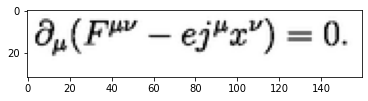

In [28]:
# ********************************************************************
# **********************  Get data  **********************************
# ********************************************************************
data_builder = DataBuilder()

vocabulary = data_builder.get_vocabulary()

force = True
train_dataset = data_builder.get_dataset_for('train', max_count=num_data_train, force=force)
valid_dataset = data_builder.get_dataset_for('validate', max_count=num_data_val, force=force)
test_dataset = data_builder.get_dataset_for('test', max_count=num_data_test, force=force)

num_data_train = len(train_dataset)
num_data_val = len(valid_dataset)
num_data_test = len(test_dataset)
print(num_data_train)
print(num_data_val)
print(num_data_test)

show_tensor_as_image(train_dataset[6][0])

In [7]:
# ********************************************************************
# **********************  Architecture  ******************************
# ********************************************************************

model = Model(
out_size=len(vocabulary),
enc_out_dim=512,
emb_size=80,
dec_rnn_h=512,
dropout=drop_out
)

In [8]:
# ********************************************************************
# **********************  Training  **********************************
# ********************************************************************

# Hyper parameters for training 
init_epoch = 1

# For epsilon calculation
decay_k = 1 #default
sample_method = "inv_sigmoid" #default ["exp", "inv_sigmoid", "teacher_forcing")

# Dataloaders
train_loader = DataLoader (
    train_dataset,
    batch_size=batch_size,
    #TODO how collate works?
    # https://discuss.pytorch.org/t/how-to-create-a-dataloader-with-variable-size-input/8278
    collate_fn=partial(collate_fn, vocabulary.token_id_dic),
    pin_memory=False, # It must be False (no GPU): https://discuss.pytorch.org/t/when-to-set-pin-memory-to-true/19723
    #shuffle=True,
    num_workers=num_workers
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    collate_fn=partial(collate_fn, vocabulary.token_id_dic)
    )


In [9]:
# Optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
lr_scheduler = ReduceLROnPlateau(
    optimizer,
    "min",
    factor=0.5, # float default - Learning rate decay rate
    patience=3, # int default - Learning rate decay patience
    verbose=True,
    min_lr=3e-5) # default 3e-5

In [10]:
# Variables to save results
training_losses = []
valid_losses = []
total_step = 0
best_valid_loss = 1e18

In [11]:
# For profiling
logger = TrainingLogger(print_freq=10)

for epoch in range(epochs):
    step_losses = []
    step = 1

    # Training
    model.train()
    loader_len = len(train_loader)
    for imgs_batch, tgt4training_batch, tgt4loss_batch in train_loader:
        optimizer.zero_grad()

        # Epsilon
        #epsilon = cal_epsilon(decay_k, total_step, sample_method)

        # Prediction
        logits = model(imgs_batch, tgt4training_batch, 1.)

        # Compute Loss
        step_loss = cal_loss(logits, tgt4loss_batch)
            
        # Add loss
        step_losses.append(step_loss.item())

        # Print results
        logger.log_train_step(epoch+1, epochs, step, loader_len, statistics.mean(step_losses))

        # Updates
        step_loss.backward()
        clip_grad_norm_(model.parameters(),clip)
        optimizer.step()

        step += 1
        total_step += 1
        
    training_losses.append(statistics.mean(step_losses))

+++++++++++++++ Training initialized +++++++++++++++
[Train] Epoch 1/4 Step 10/7528 Loss 5.467695
[Train] Epoch 1/4 Step 20/7528 Loss 4.930027
[Train] Epoch 1/4 Step 30/7528 Loss 4.656037
[Train] Epoch 1/4 Step 40/7528 Loss 4.488641
[Train] Epoch 1/4 Step 50/7528 Loss 4.408816
[Train] Epoch 1/4 Step 60/7528 Loss 4.347257
[Train] Epoch 1/4 Step 70/7528 Loss 4.270714
[Train] Epoch 1/4 Step 80/7528 Loss 4.225239
[Train] Epoch 1/4 Step 90/7528 Loss 4.163201
[Train] Epoch 1/4 Step 100/7528 Loss 4.115012
[Train] Epoch 1/4 Step 110/7528 Loss 4.065625
[Train] Epoch 1/4 Step 120/7528 Loss 4.022969
[Train] Epoch 1/4 Step 130/7528 Loss 3.981177
[Train] Epoch 1/4 Step 140/7528 Loss 3.949805
[Train] Epoch 1/4 Step 150/7528 Loss 3.916355
[Train] Epoch 1/4 Step 160/7528 Loss 3.889586
[Train] Epoch 1/4 Step 170/7528 Loss 3.846480
[Train] Epoch 1/4 Step 180/7528 Loss 3.828449
[Train] Epoch 1/4 Step 190/7528 Loss 3.798357
[Train] Epoch 1/4 Step 200/7528 Loss 3.764735
[Train] Epoch 1/4 Step 210/7528 Loss

[Train] Epoch 1/4 Step 1770/7528 Loss 2.952067
[Train] Epoch 1/4 Step 1780/7528 Loss 2.951363
[Train] Epoch 1/4 Step 1790/7528 Loss 2.950089
[Train] Epoch 1/4 Step 1800/7528 Loss 2.948006
[Train] Epoch 1/4 Step 1810/7528 Loss 2.946964
[Train] Epoch 1/4 Step 1820/7528 Loss 2.946070
[Train] Epoch 1/4 Step 1830/7528 Loss 2.943908
[Train] Epoch 1/4 Step 1840/7528 Loss 2.942109
[Train] Epoch 1/4 Step 1850/7528 Loss 2.940463
[Train] Epoch 1/4 Step 1860/7528 Loss 2.938742
[Train] Epoch 1/4 Step 1870/7528 Loss 2.936880
[Train] Epoch 1/4 Step 1880/7528 Loss 2.934480
[Train] Epoch 1/4 Step 1890/7528 Loss 2.933151
[Train] Epoch 1/4 Step 1900/7528 Loss 2.932048
[Train] Epoch 1/4 Step 1910/7528 Loss 2.930568
[Train] Epoch 1/4 Step 1920/7528 Loss 2.929718
[Train] Epoch 1/4 Step 1930/7528 Loss 2.928140
[Train] Epoch 1/4 Step 1940/7528 Loss 2.926096
[Train] Epoch 1/4 Step 1950/7528 Loss 2.925556
[Train] Epoch 1/4 Step 1960/7528 Loss 2.923650
[Train] Epoch 1/4 Step 1970/7528 Loss 2.921554
[Train] Epoch

[Train] Epoch 1/4 Step 3520/7528 Loss 2.784262
[Train] Epoch 1/4 Step 3530/7528 Loss 2.782915
[Train] Epoch 1/4 Step 3540/7528 Loss 2.781947
[Train] Epoch 1/4 Step 3550/7528 Loss 2.781480
[Train] Epoch 1/4 Step 3560/7528 Loss 2.781270
[Train] Epoch 1/4 Step 3570/7528 Loss 2.780215
[Train] Epoch 1/4 Step 3580/7528 Loss 2.779862
[Train] Epoch 1/4 Step 3590/7528 Loss 2.779111
[Train] Epoch 1/4 Step 3600/7528 Loss 2.778159
[Train] Epoch 1/4 Step 3610/7528 Loss 2.777752
[Train] Epoch 1/4 Step 3620/7528 Loss 2.776887
[Train] Epoch 1/4 Step 3630/7528 Loss 2.776005
[Train] Epoch 1/4 Step 3640/7528 Loss 2.775980
[Train] Epoch 1/4 Step 3650/7528 Loss 2.775054
[Train] Epoch 1/4 Step 3660/7528 Loss 2.774057
[Train] Epoch 1/4 Step 3670/7528 Loss 2.773327
[Train] Epoch 1/4 Step 3680/7528 Loss 2.773074
[Train] Epoch 1/4 Step 3690/7528 Loss 2.772803
[Train] Epoch 1/4 Step 3700/7528 Loss 2.772752
[Train] Epoch 1/4 Step 3710/7528 Loss 2.771446
[Train] Epoch 1/4 Step 3720/7528 Loss 2.771011
[Train] Epoch

[Train] Epoch 1/4 Step 5270/7528 Loss 2.697975
[Train] Epoch 1/4 Step 5280/7528 Loss 2.697392
[Train] Epoch 1/4 Step 5290/7528 Loss 2.696668
[Train] Epoch 1/4 Step 5300/7528 Loss 2.696759
[Train] Epoch 1/4 Step 5310/7528 Loss 2.696635
[Train] Epoch 1/4 Step 5320/7528 Loss 2.696525
[Train] Epoch 1/4 Step 5330/7528 Loss 2.696111
[Train] Epoch 1/4 Step 5340/7528 Loss 2.695379
[Train] Epoch 1/4 Step 5350/7528 Loss 2.694899
[Train] Epoch 1/4 Step 5360/7528 Loss 2.694712
[Train] Epoch 1/4 Step 5370/7528 Loss 2.694567
[Train] Epoch 1/4 Step 5380/7528 Loss 2.694343
[Train] Epoch 1/4 Step 5390/7528 Loss 2.693627
[Train] Epoch 1/4 Step 5400/7528 Loss 2.693144
[Train] Epoch 1/4 Step 5410/7528 Loss 2.692587
[Train] Epoch 1/4 Step 5420/7528 Loss 2.692336
[Train] Epoch 1/4 Step 5430/7528 Loss 2.692246
[Train] Epoch 1/4 Step 5440/7528 Loss 2.691812
[Train] Epoch 1/4 Step 5450/7528 Loss 2.691287
[Train] Epoch 1/4 Step 5460/7528 Loss 2.690896
[Train] Epoch 1/4 Step 5470/7528 Loss 2.691218
[Train] Epoch

[Train] Epoch 1/4 Step 7020/7528 Loss 2.633528
[Train] Epoch 1/4 Step 7030/7528 Loss 2.633334
[Train] Epoch 1/4 Step 7040/7528 Loss 2.632872
[Train] Epoch 1/4 Step 7050/7528 Loss 2.632471
[Train] Epoch 1/4 Step 7060/7528 Loss 2.632436
[Train] Epoch 1/4 Step 7070/7528 Loss 2.632115
[Train] Epoch 1/4 Step 7080/7528 Loss 2.631734
[Train] Epoch 1/4 Step 7090/7528 Loss 2.631556
[Train] Epoch 1/4 Step 7100/7528 Loss 2.631366
[Train] Epoch 1/4 Step 7110/7528 Loss 2.631406
[Train] Epoch 1/4 Step 7120/7528 Loss 2.631134
[Train] Epoch 1/4 Step 7130/7528 Loss 2.630658
[Train] Epoch 1/4 Step 7140/7528 Loss 2.630230
[Train] Epoch 1/4 Step 7150/7528 Loss 2.629887
[Train] Epoch 1/4 Step 7160/7528 Loss 2.629365
[Train] Epoch 1/4 Step 7170/7528 Loss 2.628878
[Train] Epoch 1/4 Step 7180/7528 Loss 2.628532
[Train] Epoch 1/4 Step 7190/7528 Loss 2.627944
[Train] Epoch 1/4 Step 7200/7528 Loss 2.627695
[Train] Epoch 1/4 Step 7210/7528 Loss 2.627456
[Train] Epoch 1/4 Step 7220/7528 Loss 2.627123
[Train] Epoch

[Train] Epoch 2/4 Step 1270/7528 Loss 2.415090
[Train] Epoch 2/4 Step 1280/7528 Loss 2.413270
[Train] Epoch 2/4 Step 1290/7528 Loss 2.411319
[Train] Epoch 2/4 Step 1300/7528 Loss 2.411754
[Train] Epoch 2/4 Step 1310/7528 Loss 2.412732
[Train] Epoch 2/4 Step 1320/7528 Loss 2.412339
[Train] Epoch 2/4 Step 1330/7528 Loss 2.410840
[Train] Epoch 2/4 Step 1340/7528 Loss 2.410481
[Train] Epoch 2/4 Step 1350/7528 Loss 2.410394
[Train] Epoch 2/4 Step 1360/7528 Loss 2.410495
[Train] Epoch 2/4 Step 1370/7528 Loss 2.408264
[Train] Epoch 2/4 Step 1380/7528 Loss 2.408255
[Train] Epoch 2/4 Step 1390/7528 Loss 2.407074
[Train] Epoch 2/4 Step 1400/7528 Loss 2.407771
[Train] Epoch 2/4 Step 1410/7528 Loss 2.406525
[Train] Epoch 2/4 Step 1420/7528 Loss 2.404866
[Train] Epoch 2/4 Step 1430/7528 Loss 2.403035
[Train] Epoch 2/4 Step 1440/7528 Loss 2.402541
[Train] Epoch 2/4 Step 1450/7528 Loss 2.401465
[Train] Epoch 2/4 Step 1460/7528 Loss 2.401895
[Train] Epoch 2/4 Step 1470/7528 Loss 2.401339
[Train] Epoch

[Train] Epoch 2/4 Step 3020/7528 Loss 2.384144
[Train] Epoch 2/4 Step 3030/7528 Loss 2.383809
[Train] Epoch 2/4 Step 3040/7528 Loss 2.382976
[Train] Epoch 2/4 Step 3050/7528 Loss 2.382748
[Train] Epoch 2/4 Step 3060/7528 Loss 2.381898
[Train] Epoch 2/4 Step 3070/7528 Loss 2.381589
[Train] Epoch 2/4 Step 3080/7528 Loss 2.381950
[Train] Epoch 2/4 Step 3090/7528 Loss 2.381571
[Train] Epoch 2/4 Step 3100/7528 Loss 2.381365
[Train] Epoch 2/4 Step 3110/7528 Loss 2.381394
[Train] Epoch 2/4 Step 3120/7528 Loss 2.381430
[Train] Epoch 2/4 Step 3130/7528 Loss 2.380776
[Train] Epoch 2/4 Step 3140/7528 Loss 2.380342
[Train] Epoch 2/4 Step 3150/7528 Loss 2.379726
[Train] Epoch 2/4 Step 3160/7528 Loss 2.379825
[Train] Epoch 2/4 Step 3170/7528 Loss 2.379656
[Train] Epoch 2/4 Step 3180/7528 Loss 2.379256
[Train] Epoch 2/4 Step 3190/7528 Loss 2.378945
[Train] Epoch 2/4 Step 3200/7528 Loss 2.378500
[Train] Epoch 2/4 Step 3210/7528 Loss 2.378364
[Train] Epoch 2/4 Step 3220/7528 Loss 2.377885
[Train] Epoch

[Train] Epoch 2/4 Step 4770/7528 Loss 2.369548
[Train] Epoch 2/4 Step 4780/7528 Loss 2.369614
[Train] Epoch 2/4 Step 4790/7528 Loss 2.369621
[Train] Epoch 2/4 Step 4800/7528 Loss 2.369336
[Train] Epoch 2/4 Step 4810/7528 Loss 2.369537
[Train] Epoch 2/4 Step 4820/7528 Loss 2.369492
[Train] Epoch 2/4 Step 4830/7528 Loss 2.369477
[Train] Epoch 2/4 Step 4840/7528 Loss 2.369282
[Train] Epoch 2/4 Step 4850/7528 Loss 2.369597
[Train] Epoch 2/4 Step 4860/7528 Loss 2.369511
[Train] Epoch 2/4 Step 4870/7528 Loss 2.369460
[Train] Epoch 2/4 Step 4880/7528 Loss 2.369476
[Train] Epoch 2/4 Step 4890/7528 Loss 2.369152
[Train] Epoch 2/4 Step 4900/7528 Loss 2.370096
[Train] Epoch 2/4 Step 4910/7528 Loss 2.369683
[Train] Epoch 2/4 Step 4920/7528 Loss 2.369836
[Train] Epoch 2/4 Step 4930/7528 Loss 2.369601
[Train] Epoch 2/4 Step 4940/7528 Loss 2.369423
[Train] Epoch 2/4 Step 4950/7528 Loss 2.369174
[Train] Epoch 2/4 Step 4960/7528 Loss 2.369170
[Train] Epoch 2/4 Step 4970/7528 Loss 2.368930
[Train] Epoch

[Train] Epoch 2/4 Step 6520/7528 Loss 2.353787
[Train] Epoch 2/4 Step 6530/7528 Loss 2.353782
[Train] Epoch 2/4 Step 6540/7528 Loss 2.353676
[Train] Epoch 2/4 Step 6550/7528 Loss 2.353742
[Train] Epoch 2/4 Step 6560/7528 Loss 2.353746
[Train] Epoch 2/4 Step 6570/7528 Loss 2.353571
[Train] Epoch 2/4 Step 6580/7528 Loss 2.353332
[Train] Epoch 2/4 Step 6590/7528 Loss 2.353102
[Train] Epoch 2/4 Step 6600/7528 Loss 2.352914
[Train] Epoch 2/4 Step 6610/7528 Loss 2.352814
[Train] Epoch 2/4 Step 6620/7528 Loss 2.352993
[Train] Epoch 2/4 Step 6630/7528 Loss 2.352721
[Train] Epoch 2/4 Step 6640/7528 Loss 2.352536
[Train] Epoch 2/4 Step 6650/7528 Loss 2.352418
[Train] Epoch 2/4 Step 6660/7528 Loss 2.352374
[Train] Epoch 2/4 Step 6670/7528 Loss 2.352160
[Train] Epoch 2/4 Step 6680/7528 Loss 2.352020
[Train] Epoch 2/4 Step 6690/7528 Loss 2.352301
[Train] Epoch 2/4 Step 6700/7528 Loss 2.352196
[Train] Epoch 2/4 Step 6710/7528 Loss 2.351990
[Train] Epoch 2/4 Step 6720/7528 Loss 2.351820
[Train] Epoch

[Train] Epoch 3/4 Step 770/7528 Loss 2.323009
[Train] Epoch 3/4 Step 780/7528 Loss 2.322268
[Train] Epoch 3/4 Step 790/7528 Loss 2.320838
[Train] Epoch 3/4 Step 800/7528 Loss 2.317989
[Train] Epoch 3/4 Step 810/7528 Loss 2.316484
[Train] Epoch 3/4 Step 820/7528 Loss 2.316088
[Train] Epoch 3/4 Step 830/7528 Loss 2.314601
[Train] Epoch 3/4 Step 840/7528 Loss 2.316591
[Train] Epoch 3/4 Step 850/7528 Loss 2.315178
[Train] Epoch 3/4 Step 860/7528 Loss 2.314959
[Train] Epoch 3/4 Step 870/7528 Loss 2.314435
[Train] Epoch 3/4 Step 880/7528 Loss 2.314402
[Train] Epoch 3/4 Step 890/7528 Loss 2.314330
[Train] Epoch 3/4 Step 900/7528 Loss 2.309814
[Train] Epoch 3/4 Step 910/7528 Loss 2.307708
[Train] Epoch 3/4 Step 920/7528 Loss 2.309096
[Train] Epoch 3/4 Step 930/7528 Loss 2.308009
[Train] Epoch 3/4 Step 940/7528 Loss 2.308105
[Train] Epoch 3/4 Step 950/7528 Loss 2.307184
[Train] Epoch 3/4 Step 960/7528 Loss 2.308090
[Train] Epoch 3/4 Step 970/7528 Loss 2.307401
[Train] Epoch 3/4 Step 980/7528 Lo

[Train] Epoch 3/4 Step 2520/7528 Loss 2.290878
[Train] Epoch 3/4 Step 2530/7528 Loss 2.291379
[Train] Epoch 3/4 Step 2540/7528 Loss 2.290707
[Train] Epoch 3/4 Step 2550/7528 Loss 2.291102
[Train] Epoch 3/4 Step 2560/7528 Loss 2.291036
[Train] Epoch 3/4 Step 2570/7528 Loss 2.291196
[Train] Epoch 3/4 Step 2580/7528 Loss 2.290751
[Train] Epoch 3/4 Step 2590/7528 Loss 2.291587
[Train] Epoch 3/4 Step 2600/7528 Loss 2.291669
[Train] Epoch 3/4 Step 2610/7528 Loss 2.291636
[Train] Epoch 3/4 Step 2620/7528 Loss 2.291455
[Train] Epoch 3/4 Step 2630/7528 Loss 2.292406
[Train] Epoch 3/4 Step 2640/7528 Loss 2.292259
[Train] Epoch 3/4 Step 2650/7528 Loss 2.292936
[Train] Epoch 3/4 Step 2660/7528 Loss 2.293168
[Train] Epoch 3/4 Step 2670/7528 Loss 2.294730
[Train] Epoch 3/4 Step 2680/7528 Loss 2.295176
[Train] Epoch 3/4 Step 2690/7528 Loss 2.294525
[Train] Epoch 3/4 Step 2700/7528 Loss 2.294551
[Train] Epoch 3/4 Step 2710/7528 Loss 2.293822
[Train] Epoch 3/4 Step 2720/7528 Loss 2.292760
[Train] Epoch

[Train] Epoch 3/4 Step 4270/7528 Loss 2.277311
[Train] Epoch 3/4 Step 4280/7528 Loss 2.277500
[Train] Epoch 3/4 Step 4290/7528 Loss 2.277293
[Train] Epoch 3/4 Step 4300/7528 Loss 2.277564
[Train] Epoch 3/4 Step 4310/7528 Loss 2.277666
[Train] Epoch 3/4 Step 4320/7528 Loss 2.277618
[Train] Epoch 3/4 Step 4330/7528 Loss 2.277619
[Train] Epoch 3/4 Step 4340/7528 Loss 2.277727
[Train] Epoch 3/4 Step 4350/7528 Loss 2.277087
[Train] Epoch 3/4 Step 4360/7528 Loss 2.277241
[Train] Epoch 3/4 Step 4370/7528 Loss 2.276915
[Train] Epoch 3/4 Step 4380/7528 Loss 2.276423
[Train] Epoch 3/4 Step 4390/7528 Loss 2.275948
[Train] Epoch 3/4 Step 4400/7528 Loss 2.276156
[Train] Epoch 3/4 Step 4410/7528 Loss 2.276567
[Train] Epoch 3/4 Step 4420/7528 Loss 2.276485
[Train] Epoch 3/4 Step 4430/7528 Loss 2.276429
[Train] Epoch 3/4 Step 4440/7528 Loss 2.276406
[Train] Epoch 3/4 Step 4450/7528 Loss 2.276023
[Train] Epoch 3/4 Step 4460/7528 Loss 2.276061
[Train] Epoch 3/4 Step 4470/7528 Loss 2.275739
[Train] Epoch

[Train] Epoch 3/4 Step 6020/7528 Loss 2.267952
[Train] Epoch 3/4 Step 6030/7528 Loss 2.267770
[Train] Epoch 3/4 Step 6040/7528 Loss 2.267313
[Train] Epoch 3/4 Step 6050/7528 Loss 2.267582
[Train] Epoch 3/4 Step 6060/7528 Loss 2.267422
[Train] Epoch 3/4 Step 6070/7528 Loss 2.267077
[Train] Epoch 3/4 Step 6080/7528 Loss 2.267073
[Train] Epoch 3/4 Step 6090/7528 Loss 2.267181
[Train] Epoch 3/4 Step 6100/7528 Loss 2.267106
[Train] Epoch 3/4 Step 6110/7528 Loss 2.266877
[Train] Epoch 3/4 Step 6120/7528 Loss 2.266897
[Train] Epoch 3/4 Step 6130/7528 Loss 2.267035
[Train] Epoch 3/4 Step 6140/7528 Loss 2.266871
[Train] Epoch 3/4 Step 6150/7528 Loss 2.266854
[Train] Epoch 3/4 Step 6160/7528 Loss 2.266796
[Train] Epoch 3/4 Step 6170/7528 Loss 2.266677
[Train] Epoch 3/4 Step 6180/7528 Loss 2.266801
[Train] Epoch 3/4 Step 6190/7528 Loss 2.266500
[Train] Epoch 3/4 Step 6200/7528 Loss 2.266592
[Train] Epoch 3/4 Step 6210/7528 Loss 2.266415
[Train] Epoch 3/4 Step 6220/7528 Loss 2.266927
[Train] Epoch

[Train] Epoch 4/4 Step 260/7528 Loss 2.270741
[Train] Epoch 4/4 Step 270/7528 Loss 2.265484
[Train] Epoch 4/4 Step 280/7528 Loss 2.260505
[Train] Epoch 4/4 Step 290/7528 Loss 2.267480
[Train] Epoch 4/4 Step 300/7528 Loss 2.263669
[Train] Epoch 4/4 Step 310/7528 Loss 2.259592
[Train] Epoch 4/4 Step 320/7528 Loss 2.260735
[Train] Epoch 4/4 Step 330/7528 Loss 2.261206
[Train] Epoch 4/4 Step 340/7528 Loss 2.260310
[Train] Epoch 4/4 Step 350/7528 Loss 2.261605
[Train] Epoch 4/4 Step 360/7528 Loss 2.255463
[Train] Epoch 4/4 Step 370/7528 Loss 2.253723
[Train] Epoch 4/4 Step 380/7528 Loss 2.258965
[Train] Epoch 4/4 Step 390/7528 Loss 2.261812
[Train] Epoch 4/4 Step 400/7528 Loss 2.266023
[Train] Epoch 4/4 Step 410/7528 Loss 2.272831
[Train] Epoch 4/4 Step 420/7528 Loss 2.267113
[Train] Epoch 4/4 Step 430/7528 Loss 2.267617
[Train] Epoch 4/4 Step 440/7528 Loss 2.267862
[Train] Epoch 4/4 Step 450/7528 Loss 2.269370
[Train] Epoch 4/4 Step 460/7528 Loss 2.267351
[Train] Epoch 4/4 Step 470/7528 Lo

[Train] Epoch 4/4 Step 2020/7528 Loss 2.204563
[Train] Epoch 4/4 Step 2030/7528 Loss 2.204269
[Train] Epoch 4/4 Step 2040/7528 Loss 2.203868
[Train] Epoch 4/4 Step 2050/7528 Loss 2.203781
[Train] Epoch 4/4 Step 2060/7528 Loss 2.203050
[Train] Epoch 4/4 Step 2070/7528 Loss 2.202527
[Train] Epoch 4/4 Step 2080/7528 Loss 2.202278
[Train] Epoch 4/4 Step 2090/7528 Loss 2.202581
[Train] Epoch 4/4 Step 2100/7528 Loss 2.202457
[Train] Epoch 4/4 Step 2110/7528 Loss 2.202059
[Train] Epoch 4/4 Step 2120/7528 Loss 2.202114
[Train] Epoch 4/4 Step 2130/7528 Loss 2.202303
[Train] Epoch 4/4 Step 2140/7528 Loss 2.201685
[Train] Epoch 4/4 Step 2150/7528 Loss 2.201850
[Train] Epoch 4/4 Step 2160/7528 Loss 2.201744
[Train] Epoch 4/4 Step 2170/7528 Loss 2.201826
[Train] Epoch 4/4 Step 2180/7528 Loss 2.200982
[Train] Epoch 4/4 Step 2190/7528 Loss 2.202977
[Train] Epoch 4/4 Step 2200/7528 Loss 2.202038
[Train] Epoch 4/4 Step 2210/7528 Loss 2.203107
[Train] Epoch 4/4 Step 2220/7528 Loss 2.203657
[Train] Epoch

[Train] Epoch 4/4 Step 3770/7528 Loss 2.189631
[Train] Epoch 4/4 Step 3780/7528 Loss 2.189966
[Train] Epoch 4/4 Step 3790/7528 Loss 2.190378
[Train] Epoch 4/4 Step 3800/7528 Loss 2.190794
[Train] Epoch 4/4 Step 3810/7528 Loss 2.190342
[Train] Epoch 4/4 Step 3820/7528 Loss 2.189812
[Train] Epoch 4/4 Step 3830/7528 Loss 2.189773
[Train] Epoch 4/4 Step 3840/7528 Loss 2.189712
[Train] Epoch 4/4 Step 3850/7528 Loss 2.189960
[Train] Epoch 4/4 Step 3860/7528 Loss 2.189907
[Train] Epoch 4/4 Step 3870/7528 Loss 2.189848
[Train] Epoch 4/4 Step 3880/7528 Loss 2.190226
[Train] Epoch 4/4 Step 3890/7528 Loss 2.190415
[Train] Epoch 4/4 Step 3900/7528 Loss 2.190443
[Train] Epoch 4/4 Step 3910/7528 Loss 2.191076
[Train] Epoch 4/4 Step 3920/7528 Loss 2.191081
[Train] Epoch 4/4 Step 3930/7528 Loss 2.191063
[Train] Epoch 4/4 Step 3940/7528 Loss 2.191163
[Train] Epoch 4/4 Step 3950/7528 Loss 2.192041
[Train] Epoch 4/4 Step 3960/7528 Loss 2.191697
[Train] Epoch 4/4 Step 3970/7528 Loss 2.192217
[Train] Epoch

[Train] Epoch 4/4 Step 5520/7528 Loss 2.183900
[Train] Epoch 4/4 Step 5530/7528 Loss 2.183849
[Train] Epoch 4/4 Step 5540/7528 Loss 2.183855
[Train] Epoch 4/4 Step 5550/7528 Loss 2.183531
[Train] Epoch 4/4 Step 5560/7528 Loss 2.183331
[Train] Epoch 4/4 Step 5570/7528 Loss 2.183504
[Train] Epoch 4/4 Step 5580/7528 Loss 2.183520
[Train] Epoch 4/4 Step 5590/7528 Loss 2.183511
[Train] Epoch 4/4 Step 5600/7528 Loss 2.183088
[Train] Epoch 4/4 Step 5610/7528 Loss 2.183041
[Train] Epoch 4/4 Step 5620/7528 Loss 2.182554
[Train] Epoch 4/4 Step 5630/7528 Loss 2.182196
[Train] Epoch 4/4 Step 5640/7528 Loss 2.181994
[Train] Epoch 4/4 Step 5650/7528 Loss 2.181620
[Train] Epoch 4/4 Step 5660/7528 Loss 2.181605
[Train] Epoch 4/4 Step 5670/7528 Loss 2.181383
[Train] Epoch 4/4 Step 5680/7528 Loss 2.181436
[Train] Epoch 4/4 Step 5690/7528 Loss 2.181560
[Train] Epoch 4/4 Step 5700/7528 Loss 2.181760
[Train] Epoch 4/4 Step 5710/7528 Loss 2.181400
[Train] Epoch 4/4 Step 5720/7528 Loss 2.181147
[Train] Epoch

[Train] Epoch 4/4 Step 7270/7528 Loss 2.166153
[Train] Epoch 4/4 Step 7280/7528 Loss 2.166252
[Train] Epoch 4/4 Step 7290/7528 Loss 2.166152
[Train] Epoch 4/4 Step 7300/7528 Loss 2.166182
[Train] Epoch 4/4 Step 7310/7528 Loss 2.166068
[Train] Epoch 4/4 Step 7320/7528 Loss 2.166139
[Train] Epoch 4/4 Step 7330/7528 Loss 2.165897
[Train] Epoch 4/4 Step 7340/7528 Loss 2.165912
[Train] Epoch 4/4 Step 7350/7528 Loss 2.165429
[Train] Epoch 4/4 Step 7360/7528 Loss 2.165330
[Train] Epoch 4/4 Step 7370/7528 Loss 2.165221
[Train] Epoch 4/4 Step 7380/7528 Loss 2.165104
[Train] Epoch 4/4 Step 7390/7528 Loss 2.164978
[Train] Epoch 4/4 Step 7400/7528 Loss 2.164978
[Train] Epoch 4/4 Step 7410/7528 Loss 2.165162
[Train] Epoch 4/4 Step 7420/7528 Loss 2.164987
[Train] Epoch 4/4 Step 7430/7528 Loss 2.164955
[Train] Epoch 4/4 Step 7440/7528 Loss 2.165127
[Train] Epoch 4/4 Step 7450/7528 Loss 2.164988
[Train] Epoch 4/4 Step 7460/7528 Loss 2.164639
[Train] Epoch 4/4 Step 7470/7528 Loss 2.164604
[Train] Epoch

In [19]:
    # Validation
    model.eval()
    step_losses = []
    with torch.no_grad(): # This disable any gradient calculation (better performance)
        for imgs_batch, tgt4training, tgt4loss_batch in valid_loader:

            # Epsilon
            #epsilon = cal_epsilon(decay_k, total_step, sample_method)

            # Prediction
            pred = model(imgs_batch, tgt4training, 1.)

            # Compute loss
            step_loss = cal_loss(pred, tgt4loss_batch)
            step_losses.append(step_loss.item()) 

            # Print results
            logger.log_val_step(epoch+1, epochs, statistics.mean(step_losses))
   

[Valid] Epoch 4/4 Loss 2.1746
[Valid] Epoch 4/4 Loss 2.1740
[Valid] Epoch 4/4 Loss 1.9877
[Valid] Epoch 4/4 Loss 1.8878
[Valid] Epoch 4/4 Loss 2.0266
[Valid] Epoch 4/4 Loss 1.9736
[Valid] Epoch 4/4 Loss 1.9567
[Valid] Epoch 4/4 Loss 1.9552
[Valid] Epoch 4/4 Loss 1.9904
[Valid] Epoch 4/4 Loss 1.9737
[Valid] Epoch 4/4 Loss 1.9453
[Valid] Epoch 4/4 Loss 2.0410
[Valid] Epoch 4/4 Loss 2.0409
[Valid] Epoch 4/4 Loss 2.0320
[Valid] Epoch 4/4 Loss 2.0107
[Valid] Epoch 4/4 Loss 1.9952
[Valid] Epoch 4/4 Loss 1.9878
[Valid] Epoch 4/4 Loss 2.0315
[Valid] Epoch 4/4 Loss 2.0036
[Valid] Epoch 4/4 Loss 2.0016
[Valid] Epoch 4/4 Loss 1.9898
[Valid] Epoch 4/4 Loss 1.9730
[Valid] Epoch 4/4 Loss 1.9669
[Valid] Epoch 4/4 Loss 1.9771
[Valid] Epoch 4/4 Loss 1.9698
[Valid] Epoch 4/4 Loss 1.9554
[Valid] Epoch 4/4 Loss 1.9711
[Valid] Epoch 4/4 Loss 1.9632
[Valid] Epoch 4/4 Loss 1.9595
[Valid] Epoch 4/4 Loss 1.9494
[Valid] Epoch 4/4 Loss 1.9517
[Valid] Epoch 4/4 Loss 1.9471
[Valid] Epoch 4/4 Loss 1.9534
[Valid] Ep

[Valid] Epoch 4/4 Loss 2.0514
[Valid] Epoch 4/4 Loss 2.0507
[Valid] Epoch 4/4 Loss 2.0508
[Valid] Epoch 4/4 Loss 2.0523
[Valid] Epoch 4/4 Loss 2.0531
[Valid] Epoch 4/4 Loss 2.0533
[Valid] Epoch 4/4 Loss 2.0567
[Valid] Epoch 4/4 Loss 2.0636
[Valid] Epoch 4/4 Loss 2.0621
[Valid] Epoch 4/4 Loss 2.0616
[Valid] Epoch 4/4 Loss 2.0575
[Valid] Epoch 4/4 Loss 2.0559
[Valid] Epoch 4/4 Loss 2.0593
[Valid] Epoch 4/4 Loss 2.0613
[Valid] Epoch 4/4 Loss 2.0615
[Valid] Epoch 4/4 Loss 2.0617
[Valid] Epoch 4/4 Loss 2.0610
[Valid] Epoch 4/4 Loss 2.0615
[Valid] Epoch 4/4 Loss 2.0607
[Valid] Epoch 4/4 Loss 2.0612
[Valid] Epoch 4/4 Loss 2.0637
[Valid] Epoch 4/4 Loss 2.0652
[Valid] Epoch 4/4 Loss 2.0662
[Valid] Epoch 4/4 Loss 2.0659
[Valid] Epoch 4/4 Loss 2.0654
[Valid] Epoch 4/4 Loss 2.0662
[Valid] Epoch 4/4 Loss 2.0664
[Valid] Epoch 4/4 Loss 2.0669
[Valid] Epoch 4/4 Loss 2.0662
[Valid] Epoch 4/4 Loss 2.0676
[Valid] Epoch 4/4 Loss 2.0665
[Valid] Epoch 4/4 Loss 2.0694
[Valid] Epoch 4/4 Loss 2.0689
[Valid] Ep

[Valid] Epoch 4/4 Loss 2.0564
[Valid] Epoch 4/4 Loss 2.0551
[Valid] Epoch 4/4 Loss 2.0550
[Valid] Epoch 4/4 Loss 2.0545
[Valid] Epoch 4/4 Loss 2.0546
[Valid] Epoch 4/4 Loss 2.0541
[Valid] Epoch 4/4 Loss 2.0546
[Valid] Epoch 4/4 Loss 2.0563
[Valid] Epoch 4/4 Loss 2.0558
[Valid] Epoch 4/4 Loss 2.0562
[Valid] Epoch 4/4 Loss 2.0585
[Valid] Epoch 4/4 Loss 2.0580
[Valid] Epoch 4/4 Loss 2.0571
[Valid] Epoch 4/4 Loss 2.0566
[Valid] Epoch 4/4 Loss 2.0576
[Valid] Epoch 4/4 Loss 2.0573
[Valid] Epoch 4/4 Loss 2.0577
[Valid] Epoch 4/4 Loss 2.0582
[Valid] Epoch 4/4 Loss 2.0581
[Valid] Epoch 4/4 Loss 2.0584
[Valid] Epoch 4/4 Loss 2.0583
[Valid] Epoch 4/4 Loss 2.0588
[Valid] Epoch 4/4 Loss 2.0594
[Valid] Epoch 4/4 Loss 2.0600
[Valid] Epoch 4/4 Loss 2.0594
[Valid] Epoch 4/4 Loss 2.0596
[Valid] Epoch 4/4 Loss 2.0602
[Valid] Epoch 4/4 Loss 2.0610
[Valid] Epoch 4/4 Loss 2.0611
[Valid] Epoch 4/4 Loss 2.0605
[Valid] Epoch 4/4 Loss 2.0612
[Valid] Epoch 4/4 Loss 2.0615
[Valid] Epoch 4/4 Loss 2.0610
[Valid] Ep

[Valid] Epoch 4/4 Loss 2.0642
[Valid] Epoch 4/4 Loss 2.0642
[Valid] Epoch 4/4 Loss 2.0636
[Valid] Epoch 4/4 Loss 2.0633
[Valid] Epoch 4/4 Loss 2.0620
[Valid] Epoch 4/4 Loss 2.0625
[Valid] Epoch 4/4 Loss 2.0623
[Valid] Epoch 4/4 Loss 2.0621
[Valid] Epoch 4/4 Loss 2.0638
[Valid] Epoch 4/4 Loss 2.0641
[Valid] Epoch 4/4 Loss 2.0646
[Valid] Epoch 4/4 Loss 2.0640
[Valid] Epoch 4/4 Loss 2.0634
[Valid] Epoch 4/4 Loss 2.0630
[Valid] Epoch 4/4 Loss 2.0632


In [21]:
    # Best validation loss
    valid_loss = statistics.mean(step_losses)
    if valid_loss < best_valid_loss: #best valid loss
        best_valid_loss = valid_loss
        save_model("best_ckpt", model)

    # Scheduler
    lr_scheduler.step(valid_loss)
    valid_losses.append(valid_loss)

    # Save model checkpoint ckpt-e{epoch}
    save_model(f"ckpt-e{epoch+1}-vl{valid_loss:.4f}", model)

    # Print results
    logger.log_epoch(epoch+1, epochs, statistics.mean(training_losses), statistics.mean(valid_losses))

del logger

# ********************************************************************
# **********************  Testing  ***********************************
# ********************************************************************

latex_generator = LatexGenerator(model, vocabulary)

# Loader
test_loader = DataLoader(test_dataset, 
    batch_size=batch_size,
    collate_fn=partial(collate_fn, vocabulary.token_id_dic),
    pin_memory=False,
    num_workers=num_workers
)
    
imgs, tgt4training, tgt4loss_batch = next(iter(test_loader))
ref = latex_generator.idx2formulas(tgt4loss_batch)[0]
logit = latex_generator(imgs)[0]

# Testing
references = []
results = []
for imgs, tgt4training, tgt4loss_batch in test_loader:
        try:
            reference = latex_generator.idx2formulas(tgt4loss_batch)
            result = latex_generator(imgs)
            references.append(reference)
            results.append(result)
        except RuntimeError:
            break
    
save_test_data(f"res_{epochs}_{batch_size}_{int(num_data_train/1000)}k_{int(num_data_val/1000)}k_{int(num_data_test/1000)}k",references, results)


Epoch     5: reducing learning rate of group 0 to 1.5000e-04.
Saving checkpoint to /home/jessi/IA/proyecto/src/ckpt-e4-vl2.0632.pt
[Epoch finished] Epoch 4/4 TrainLoss 2.345325 ValidLoss 2.063163 Time 58379.6725833416 [s]
+++++++++++++++ Training finished +++++++++++++++


In [25]:
def review_results():
    data = load_test_data()
    logger = TestDataLogger(data)
    logger.print()
    